# [Pulser](https://pulser.readthedocs.io/en/stable/index.html)

Pulser est la plateforme logicielle de Pasqal, permettant la programmation d'ordinateur quantique à atomes neutres. Dans le cadre de HQI, vous avez accès à l'ordinateur quantique de Pasqal hébergé au TGCC.

Dans ce tutoriel Pulser, nous allons dans un premier temps voir la création d'un registre atomique ainsi que l'émission d'impulsion sur les atomes de ce registres. Puis, nous mettrons en évidence le phénomène de blocage de Rydberg, que vous comprendrez à la fin de ce tutoriel.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pulser
from pulser_simulation import QutipEmulator

## Création d'un registre atomique et visualisation des atomes et impulsions

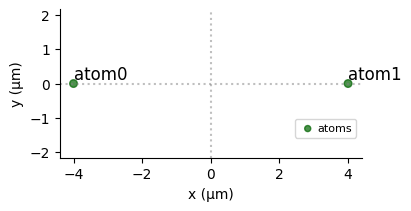

In [3]:
L = 2
line = np.array([[-4,0],[4,0]])
qubits = {"atom0": line[0], "atom1": line[1]}
reg = pulser.Register(qubits)
reg.draw()

Durée d'une impulsion défini à 1 µsec, puis création de l'impulsion pi_pulse, qui nous permettra de manipuler le registre

In [33]:
duration = 1000

pi_pulse = pulser.Pulse.ConstantDetuning(
    pulser.BlackmanWaveform(duration, np.pi), 0.0, 0.0)

Création d'un canal ciblant l'atome 0, envoie de l'impulsion puis changement de la cible pour l'atome 1, renvoie de l'impulsion.

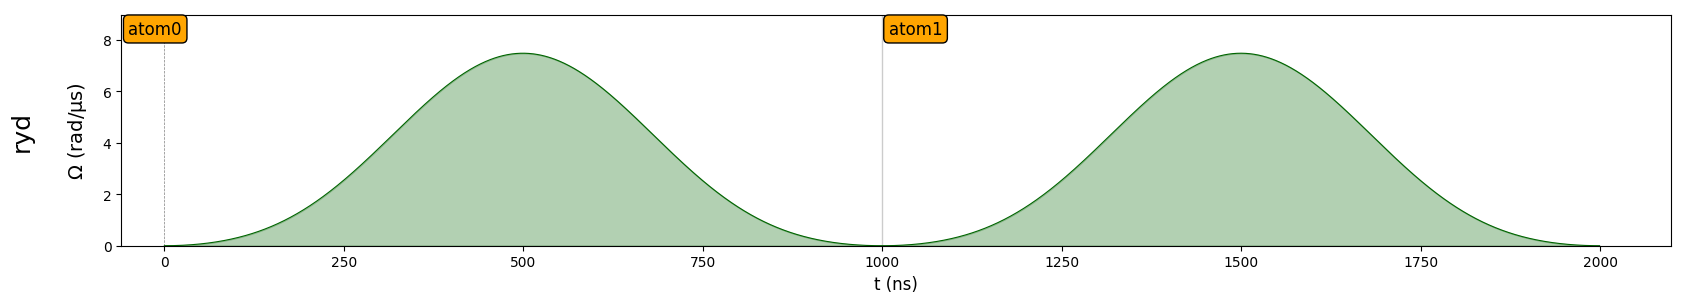

In [34]:
seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)

seq.declare_channel("ryd", "rydberg_local", "atom0")

seq.add(pi_pulse, "ryd")
seq.target("atom1", "ryd")
seq.add(pi_pulse, "ryd")

seq.draw()

Nous avons pu visualiser le registre de deux atomes, auquel nous avons envoyé indépendament des impulsions défini selon pi_pulse.

## Blocage de Rydberg

Dans cette section, nous allons explorer comment l'excitation des atomes change en fonction de la distance qui les sépare. Cela nous permettra de mettre en évidence l'effet de blocage de Rydberg, un phénomène où l'excitation d'un atome empêche l'excitation d'un autre atome à proximité en raison des fortes interactions dipolaires entre les atomes de Rydberg.

Nous allons définir la gamme de distance entre deux atomes pour notre expérience

In [35]:
data = []
distances = np.linspace(6.5, 14, 7)

In [36]:
r = [1, 0]  # |r>
rr = np.kron(r, r)  # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

Ici, nous allons, pour chaque distance de notre gamme défini plus haut, impulser pi_pulse sur les atomes du registre, en modifiant la distance d'écartement R des atomes à chaque création du registre.

In [37]:
for i, R in enumerate(distances):
    # Atom Register and Device
    reg = pulser.Register.rectangle(1, 2, spacing=R, prefix="atom")

    # Pulse Sequence
    seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)
    seq.declare_channel("ryd", "rydberg_local", "atom0")
    seq.add(pi_pulse, "ryd")
    seq.target("atom1", "ryd")
    seq.add(pi_pulse, "ryd")

    sim = QutipEmulator.from_sequence(seq)

    res = sim.run()  # Returns a SimulationResults instance
    data.append(
        res.expect(occup)[0]
    )  # Get expectation value for the occupation operator
print("...Simulation Complete!")

...Simulation Complete!


Finalement, nous pouvons observer le résultat de la simulation.

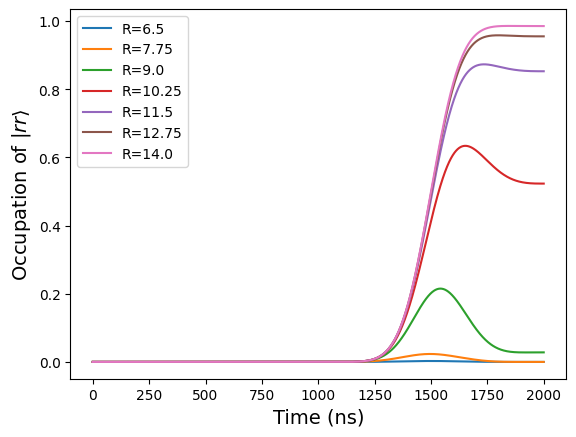

In [38]:
for i, R in enumerate(distances):
    plt.plot(data[i], label=f"R={R}")
    plt.xlabel("Time (ns)", fontsize=14)
    plt.ylabel(r"Occupation of $|rr\rangle$", fontsize=14)
    plt.legend()

On observe que plus la distance entre les atomes est grande, plus l'excitation $|rr\rangle$ est forte entre les atomes. En effet, le phénomène du blocage de Rydberg empêche un atome d'être excité si un autre atome trop proche est lui-même excité.

In [25]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.waveforms import BlackmanWaveform
from pulser.devices import DigitalAnalogDevice

In [26]:
qubits = {"control": (-2, 0), "target": (2, 0)}
reg = Register(qubits)

In [27]:
seq = Sequence(reg, DigitalAnalogDevice)
pulse_time = seq.declare_variable("pulse_time", dtype=int)
seq.declare_channel("digital", "raman_local", initial_target="control")
seq.declare_channel("rydberg", "rydberg_local", initial_target="control")

In [28]:
half_pi_wf = BlackmanWaveform(pulse_time, area=np.pi / 2)

ry = Pulse.ConstantDetuning(amplitude=half_pi_wf, detuning=0, phase=-np.pi / 2)
ry_dag = Pulse.ConstantDetuning(
    amplitude=half_pi_wf, detuning=0, phase=np.pi / 2
)

In [29]:
seq.add(ry, "digital")
seq.target("target", "digital")
seq.add(ry_dag, "digital")

In [30]:
pi_wf = BlackmanWaveform(pulse_time, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

In [31]:
max_val = DigitalAnalogDevice.rabi_from_blockade(9)
two_pi_wf = BlackmanWaveform.from_max_val(max_val, 2 * np.pi)
two_pi_pulse = Pulse.ConstantDetuning(two_pi_wf, 0, 0)

In [32]:
seq.align("digital", "rydberg")
seq.add(pi_pulse, "rydberg")
#seq.target("target", "rydberg")
#seq.add(two_pi_pulse, "rydberg")
#seq.target("control", "rydberg")
#seq.add(pi_pulse, "rydberg")

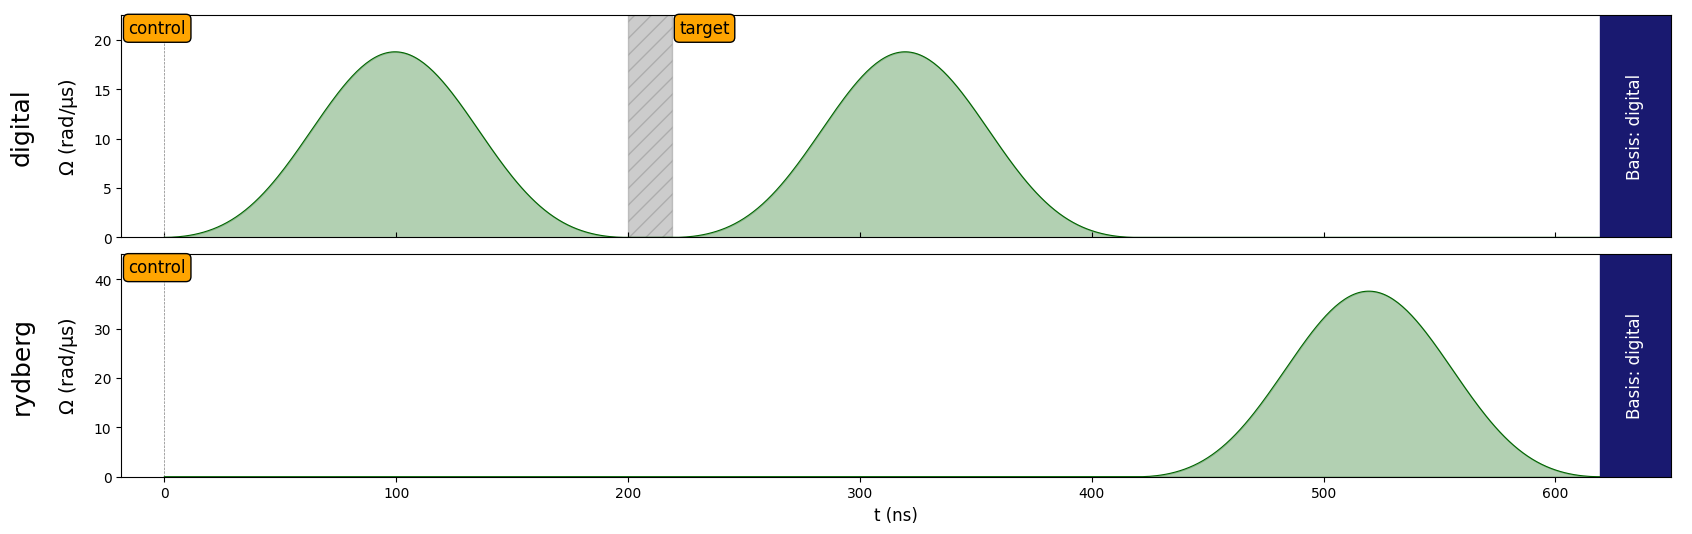

In [33]:
#seq.align("digital", "rydberg")
#seq.add(ry, "digital")
seq.measure("digital")
seq1 = seq.build(pulse_time=200)
seq1.draw()